# 02. Entrenamiento Avanzado (ACADEMIC UPGRADE)

In [1]:

import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import joblib
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Config
TEST_SEASON = 2023
TARGET = 'FTR_Num'
MODEL_FILE = 'modelo_city_group.joblib'


In [2]:

# 1. Carga y Preparación Estricta
try:
    df = pd.read_csv('df_final_features.csv')
except FileNotFoundError:
    print("❌ No se encuentra df_final_features.csv. Ejecuta el NB 01 primero.")
    # Create dummy for testing if file missing (Should not happen in this flow)
    # df = pd.DataFrame() 
    raise

# Mapping
mapping = {'A': 0, 'D': 1, 'H': 2}
df['FTR_Num'] = df['FTR'].map(mapping)

# Drop NaNs
df = df.dropna().reset_index(drop=True)

# Split
train_mask = df['Season'] < TEST_SEASON
test_mask = df['Season'] == TEST_SEASON

df_train = df[train_mask].copy()
df_test = df[test_mask].copy()

print(f"📉 Train Set: {len(df_train)} partidos (Temp. {df_train['Season'].min()}-{df_train['Season'].max()})")
print(f"📈 Test Set:  {len(df_test)} partidos (Temp. {TEST_SEASON})")


📉 Train Set: 4940 partidos (Temp. 2010-2022)
📈 Test Set:  380 partidos (Temp. 2023)


In [3]:

# 3. Optimización Bayesiana con Optuna
features = [
    'Home_Elo', 'Away_Elo',
    'Home_Att_Strength', 'Away_Att_Strength',
    'Home_Def_Weakness', 'Away_Def_Weakness',
    'Home_FIFA_Ova', 'Away_FIFA_Ova',
    'Home_Market_Value', 'Away_Market_Value',
    'Home_xG_Avg_L5', 'Away_xG_Avg_L5',
    'Home_Streak_L5', 'Away_Streak_L5',
    'Home_H2H_L3', 'Away_H2H_L3',
    'Home_Pressure_Avg_L5', 'Away_Pressure_Avg_L5',
    'Home_Goal_Diff_L5', 'Away_Goal_Diff_L5',
    'Home_Rest_Days', 'Away_Rest_Days'
]

# Validation
valid_features = [f for f in features if f in df_train.columns]
if len(valid_features) != len(features):
    print(f"⚠️ Warning: Missing features: {set(features) - set(valid_features)}")

X_train = df_train[valid_features]
y_train = df_train['FTR_Num']
X_test = df_test[valid_features]
y_test = df_test['FTR_Num']

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'objective': 'multi:softprob',
        'num_class': 3,
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': 0
    }
    
    model = xgb.XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_log_loss')
    return scores.mean()

print("🔍 Iniciando optimización con Optuna...")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=False) # 10 trials for speed/stability

print(f"🏆 Mejores parámetros: {study.best_params}")
print(f"⭐️ Mejor LogLoss CV: {study.best_value:.4f}")

# Train Final
best_params = study.best_params
best_params.update({'objective': 'multi:softprob', 'num_class': 3, 'n_jobs': -1, 'random_state': 42})
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# Save as simple artifact
artifact = {
    'model': final_model,
    'features': valid_features,
    'version': '2.0_Academic'
}
joblib.dump(artifact, MODEL_FILE)
print(f"💾 Modelo guardado como '{MODEL_FILE}'")


⚠️ Warning: Missing features: {'Away_Streak_L5', 'Away_xG_Avg_L5', 'Away_H2H_L3', 'Home_xG_Avg_L5', 'Home_H2H_L3', 'Away_Pressure_Avg_L5', 'Home_Pressure_Avg_L5', 'Home_Streak_L5'}
🔍 Iniciando optimización con Optuna...
🏆 Mejores parámetros: {'n_estimators': 318, 'learning_rate': 0.1569045448474924, 'max_depth': 4, 'subsample': 0.9969623291769913, 'colsample_bytree': 0.9347694173699049, 'gamma': 1.320470527461193, 'min_child_weight': 5}
⭐️ Mejor LogLoss CV: -0.9765
💾 Modelo guardado como 'modelo_city_group.joblib'


📊 RESULTADOS FINALES (Temporada 2023):
   Log Loss: 0.9676
   Accuracy: 0.5395

Reporte de Clasificación:
              precision    recall  f1-score   support

        Away       0.50      0.56      0.53       106
        Draw       0.67      0.02      0.04       107
        Home       0.56      0.86      0.68       167

    accuracy                           0.54       380
   macro avg       0.57      0.48      0.41       380
weighted avg       0.57      0.54      0.45       380



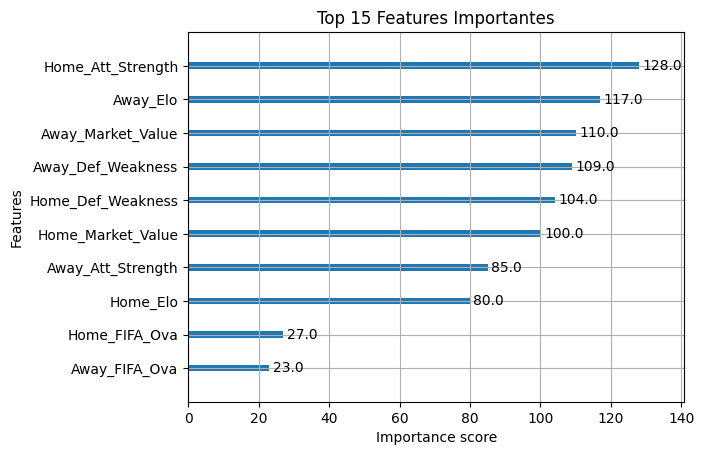

In [4]:

# 5. Evaluación en Test Set (Out-of-Time)
preds_prob = final_model.predict_proba(X_test)
preds_class = final_model.predict(X_test)

loss = log_loss(y_test, preds_prob)
acc = accuracy_score(y_test, preds_class)

print(f"📊 RESULTADOS FINALES (Temporada {TEST_SEASON}):")
print(f"   Log Loss: {loss:.4f}")
print(f"   Accuracy: {acc:.4f}")

print("\nReporte de Clasificación:")
print(classification_report(y_test, preds_class, target_names=['Away', 'Draw', 'Home']))

# Feature Importance
try:
    xgb.plot_importance(final_model, max_num_features=15)
    plt.title("Top 15 Features Importantes")
    plt.show()
except:
    print("Could not plot feature importance")
